# **Image Style Transfer Using CNNs**  
This notebook implements the method from the CVPR 2016 paper *"Image Style Transfer Using Convolutional Neural Networks"* by Leon A. Gatys et al.

The goal is to generate a new image by combining the content of one image with the style of another. This is achieved using a pre-trained CNN (such as VGG-19) to extract content and style features and optimize a noise image to match both.

### Key steps:
1. Extract content features from a specified layer of the network.
2. Extract style features using Gram matrices at multiple layers.
3. Define a total loss function (content + style) and minimize it via gradient descent.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image

In [ ]:
# defining content loss
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach() # no grad comp. req

  def forward(self, x):
    self.loss = F.mse_loss(x, self.target)
    return x

In [ ]:
# Normalized Gram matrix
def GramMatrix(input):
  batch_size, num_filters, width, height = input.size()
  N = batch_size * num_filters * width * height # use it for normalization
  tensor = input.view(batch_size * num_filters, width * height)

  Gram_matrix = torch.mm(tensor, tensor.t())
  return Gram_matrix.div(N)

In [ ]:
# define style loss
class StyleLoss(nn.Module):
  def __init__(self, input):
    super(StyleLoss, self).__init__()
    self.input = GramMatrix(input).detach()

  def forward(self, x):
    self.loss = F.mse_loss(GramMatrix(x), self.input)
    return x

Set to eval mode, because some layers will have different behaviour for training and evaluation and since we are nott training we set the mode to eval using .eval()

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval() # set to eval mode

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 100MB/s]


Note: All neural networks in torch module have been trained with tensors in range 0 and 1. So we convert the given image tensor also to that range(using normalization)

In [ ]:
layer_id = 0
model = nn.Sequential()

for layer in cnn.children():
  if isinstance(layer, nn.Conv2d):
    layer_id += 1
    name = f'conv_{layer_id}'
  elif isinstance(layer, nn.ReLU):
    name = f'relu_{layer_id}'
    layer = nn.ReLU(inplace=False) # for loss calculations
  elif isinstance(layer, nn.MaxPool2d):
    name = f'avgpool_{layer_id}'
    layer = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding) # replace maxpools with avg pools
  elif isinstance(layer, nn.BatchNorm2d):
    name = f'bn_{layer_id}'
  else:
    raise RuntimeError(f'Unrecognized layer type: {layer.__class__.__name__}')

  # add layer to the new model
  model.add_module(name, layer)

for child in model.named_children():
  print(child)

('conv_1', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_1', ReLU())
('conv_2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_2', ReLU())
('avgpool_2', AvgPool2d(kernel_size=2, stride=2, padding=0))
('conv_3', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_3', ReLU())
('conv_4', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_4', ReLU())
('avgpool_4', AvgPool2d(kernel_size=2, stride=2, padding=0))
('conv_5', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_5', ReLU())
('conv_6', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_6', ReLU())
('conv_7', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_7', ReLU())
('conv_8', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('relu_8', ReLU())
('avgpool_8', AvgPool2d(kernel_size=2, stride=2, padding=0))
('conv_9', Conv2d(256, 512, ker

In [ ]:
contentLayers = ['conv_10']
styleLayers = ['conv_1','conv_3','conv_5','conv_9','conv_13']

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
def getModel(cnn, normalization_mean, normalization_std, styleImage, contentImage, contentLayers=contentLayers, styleLayers=styleLayers):

  normalization = Normalization(normalization_mean, normalization_std)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)
  #model.add_module('norm', normalization)

  layer_id = 0

  # iterate through layers in vgg19
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      layer_id += 1
      name = f'conv_{layer_id}'
    elif isinstance(layer, nn.ReLU):
      name = f'relu_{layer_id}'
      layer = nn.ReLU(inplace=False) # for loss calculations
    elif isinstance(layer, nn.MaxPool2d):
      name = f'avgpool_{layer_id}'
      layer = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding) # replace maxpools with avg pools
    elif isinstance(layer, nn.BatchNorm2d):
      name = f'bn_{layer_id}'
    else:
      raise RuntimeError(f'Unrecognized layer type: {layer.__class__.__name__}')

    # add layer to the new model
    model.add_module(name, layer)

    # add content loss for specified layers
    if name in contentLayers:
      target = model(contentImage.detach())
      content_loss = ContentLoss(target)
      model.add_module(f"content_loss_{layer_id}", content_loss)
      content_losses.append(content_loss)

    # add style loss for specified layers
    if name in styleLayers:
      target_feature = model(styleImage.detach())
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{layer_id}", style_loss)
      style_losses.append(style_loss)

  # remove additional layers
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i + 1)]

  return model, style_losses, content_losses

Unlike training a network, we want to train the input image in order to minimize the content/style losses

In [ ]:
def get_optimizer(input_img):
  optimizer = optim.LBFGS([input_img])
  return optimizer

In [ ]:
def styleTransfer(cnn, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):

    model, style_losses, content_losses = getModel(cnn, 0, 1, style_img, content_img)

    input_img.requires_grad_(True) # since changing img to min content and style loss
    model.eval()
    model.requires_grad_(False)

    optimizer =  get_optimizer(input_img)

    print('Optimizing..')
    current_step = [0]
    while current_step[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1) # ensure values lie in 0,1 range

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            current_step[0] += 1
            if current_step[0] % 10 == 0:
              print(f"current_step {current_step}:")
              print(f'Style Loss: {style_score.item():.4f} Content Loss: {content_score.item():.4f}')

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

optimizer.step(closure) method is being used when, some optimization algorithms like LBFGS and the Conjugate gradient need to reevaluate the function multiple times, so it is needed to pass a closure that allows them to recompute our model. To compute the loss, closure should clear the gradients, and return it.



In [ ]:
im_size = (512,512)

loader = transforms.Compose([
    transforms.Resize(im_size),
    transforms.ToTensor()
])

def imageLoader(image):
  image = Image.open(image)
  image = loader(image).unsqueeze(0)
  return image

In [ ]:
def imshow(tensor, original_size):
    tensor1 = tensor.clone().squeeze(0)
    transform = transforms.ToPILImage()
    image = transform(tensor1)
    image = image.resize(original_size)  # Resize to the original size of content image
    plt.imshow(image)

Optimizing..
current_step [10]:
Style Loss: 2.3117 Content Loss: 1.8469
current_step [20]:
Style Loss: 0.9956 Content Loss: 1.3791
current_step [30]:
Style Loss: 0.6894 Content Loss: 1.1758
current_step [40]:
Style Loss: 0.5763 Content Loss: 1.0617
current_step [50]:
Style Loss: 0.5158 Content Loss: 0.9946
current_step [60]:
Style Loss: 0.4739 Content Loss: 0.9403
current_step [70]:
Style Loss: 0.4496 Content Loss: 0.8963
current_step [80]:
Style Loss: 0.4251 Content Loss: 0.8759
current_step [90]:
Style Loss: 0.4078 Content Loss: 0.8468
current_step [100]:
Style Loss: 0.3914 Content Loss: 0.8214
current_step [110]:
Style Loss: 0.3831 Content Loss: 0.8044
current_step [120]:
Style Loss: 0.3803 Content Loss: 0.7977
current_step [130]:
Style Loss: 0.3671 Content Loss: 0.7829
current_step [140]:
Style Loss: 0.3594 Content Loss: 0.7698
current_step [150]:
Style Loss: 0.3517 Content Loss: 0.7626
current_step [160]:
Style Loss: 0.3449 Content Loss: 0.7545
current_step [170]:
Style Loss: 0.33

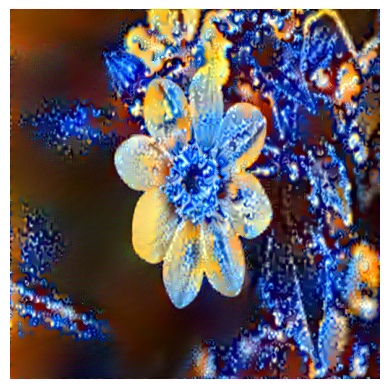

In [ ]:
content_img = imageLoader('/content/contentimage1.jpg')
style_img = imageLoader('/content/style2.jpg')
#input_img = torch.randn(result2.data.size())

output = styleTransfer(cnn, content_img=content_img, style_img=style_img, input_img=content_img)
original_size = (content_img.size(3), content_img.size(2))

#plt.figure()
imshow(output, original_size)
plt.axis('off')
plt.show()